In [12]:
'''
Solve a basic cart-pole problem, formulated as multiple shooting with Euler integration.
min_xs,us    sum_0^T-1  l(x,u) + l_T(x_T)
       s.t.     x_0 = x0
                x_t+1 = f(x_t,u_t)  for all t=0..T-1
                c(x_T) = 0

where xs = [ x_0 ... x_T ] and us = [ u_0 ... u_T-1 ]
      l,l_T are running and terminal cost functions
      f  is the integrated dynamics predicted the state at next shooting node from the state at the current
shooting node and a constant control value over the shooting interval.
      c is a terminal (hard) constraints asking the pole to be standing up with 0 velocity.

The model is stored in a so-called action-model, mostly defining the [xnext,cost] = calc(x,u) concatenating
l and f functions.

As a results, it plots the state and control trajectories.
'''

import casadi
import numpy as np
import matplotlib.pyplot as plt #; plt.ion()

### CARTPOLE HYPERPARAMS
# Hyperparameters defining the optimal control problem.
T = 50
x0 = np.array([0., 3.14, 0., 0.])
costWeightsRunning = np.array([1., 1., 0.1, 0.001, 0.001, 1.])  # sin, 1-cos, x, xdot, thdot, f
costWeightsTerminal = np.array([0,0,1,0,0,0])

### MODEL
# The action model stores the computation of the dynamic -f- and cost -l- functions.
# Calling calc with optimization variables returns a pair [xnext,cost] of symbolic expression to evaluate
# the simulation and the cost of the corresponding shooting node.
class CasadiActionModelCartPole:
    m1 = 1.
    m2 = .1
    l = .5
    g = 9.81
    dt = 5e-2
    nx = 4
    nu = 1

    def __init__(self,weights):
        self.weights = weights.copy()
        
    def calc(self,x, u=None):
        
        y     = x[0]
        th    = x[1]
        ydot  = x[2]
        thdot = x[3]
        f     = u[0] if u is not None else 0
        s, c  = casadi.sin(th), casadi.cos(th)
        
        ### Dynamics
        m = self.m1 + self.m2
        mu = self.m1 + self.m2 * s**2
        yddot = (f + self.m2 * c * s * self.g - self.m2 * self.l * s * thdot**2) / mu
        thddot = (c * f / self.l + m * self.g * s / self.l - self.m2 * c * s * thdot**2) / mu
        a = casadi.vertcat(thddot, yddot)

        ### Integration
        x_next = casadi.vertcat(x[:2] + x[-2:] * self.dt, x[-2:] + a * self.dt)

        ### Cost
        residual = casadi.vertcat(s, 1 - c, y, ydot, thdot, f)
        wresidual = residual * self.weights
        rcost = .5 * wresidual.T @ residual
        
        return x_next,rcost


In [13]:
# --- Simple Test Example ---

# 1. Define weights for the cost function
# The residual vector has 6 elements: [y, sin(th), 1-cos(th), ydot, thdot, f]
# Let's penalize angle deviation the most and control effort the least.
cost_weights = np.array([
    1.0,   # Penalty on cart position 'y'
    10.0,  # Penalty on sin(th)
    10.0,  # Penalty on 1-cos(th)
    0.1,   # Penalty on cart velocity 'ydot'
    0.1,   # Penalty on pole velocity 'thdot'
    0.01   # Penalty on control force 'f'
])

# 2. Instantiate your model with the weights
model = CasadiActionModelCartPole(weights=cost_weights)

# 3. Define an initial state [y, th, ydot, thdot]
# Let's start the cart slightly off-center with the pole slightly tilted.
x0 = np.array([0.5, 0.2, 0.0, 0.0])

# 4. Generate a random control input `u` (a single force value)
random_u = np.random.randn(1) # A random force from a normal distribution

# 5. Call the `calc` method to get the next state and cost
# We pass numpy arrays directly; CasADi handles the conversion.
x_next, running_cost = model.calc(x=x0, u=random_u)

# 6. Print the results for verification
print("--- Testing CasadiActionModelCartPole ---")
print(f"Initial State (x0): {x0}")
print(f"Random Control (u): {random_u}")
print("-" * 40)
print(f"Calculated Next State (x_next):\n{x_next}")
print(f"Calculated Running Cost (rcost): {running_cost}")

--- Testing CasadiActionModelCartPole ---
Initial State (x0): [0.5 0.2 0.  0. ]
Random Control (u): [-0.12351279]
----------------------------------------
Calculated Next State (x_next):
[0.5, 0.2, 0.201484, 0.00336158]
Calculated Running Cost (rcost): 1.2718


In [14]:
np.array(x_next)

array([[0.5       ],
       [0.2       ],
       [0.20148375],
       [0.00336158]])

<>:38: SyntaxWarning: invalid escape sequence '\d'
<>:38: SyntaxWarning: invalid escape sequence '\d'
<>:38: SyntaxWarning: invalid escape sequence '\d'
<>:38: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_88507/1482111784.py:38: SyntaxWarning: invalid escape sequence '\d'
  plt.legend(['x', '$\\theta$', '$\dot{x}$', '$\dot{\\theta}$'])
/tmp/ipykernel_88507/1482111784.py:38: SyntaxWarning: invalid escape sequence '\d'
  plt.legend(['x', '$\\theta$', '$\dot{x}$', '$\dot{\\theta}$'])



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      757
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      354

Total number of variables............................:      254
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      207
Total number of inequality c

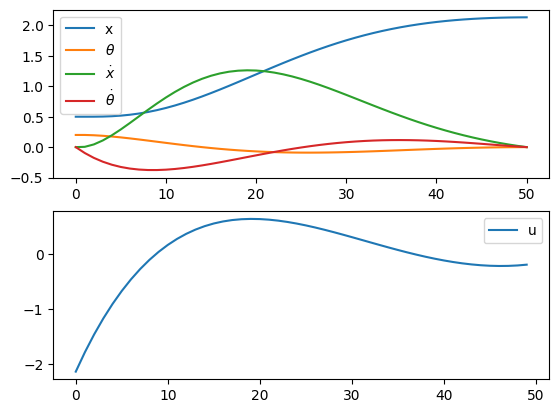

In [15]:

### PROBLEM
# Create the casadi optimal control problem
opti = casadi.Opti()
# The control models are stored as a collection of shooting nodes called running models,
# with an additional terminal model.
runningModels = [ CasadiActionModelCartPole(costWeightsRunning) for t in range(T) ]
terminalModel = CasadiActionModelCartPole(costWeightsTerminal)

# Decision variables
xs = [ opti.variable(model.nx) for model in runningModels+[terminalModel] ]     # state variable
us = [ opti.variable(model.nu) for model in runningModels ]                     # control variable

# Roll out loop, summing the integral cost and defining the shooting constraints.
totalcost = 0
opti.subject_to(xs[0] == x0)
for t in range(T):
    xnext,rcost = runningModels[t].calc(xs[t], us[t])
    opti.subject_to(xs[t + 1] == xnext )
    totalcost += rcost

# Addition terminal cost and terminal constraint
totalcost += terminalModel.calc(xs[T])[1]
opti.subject_to(xs[-1][1:] == 0)

### SOLVE
opti.minimize(totalcost)
opti.solver('ipopt')
sol = opti.solve()

# The value of the decision variable at the optimum are stored in 2 arrays.
xs_sol = np.array([ opti.value(x) for x in xs ])
us_sol = np.array([ opti.value(u) for u in us ])

### PLOT
plt.figure( 'Solutions')
plt.subplot(2,1,1)
plt.plot(xs_sol)
plt.legend(['x', '$\\theta$', '$\dot{x}$', '$\dot{\\theta}$'])

plt.subplot(2,1,2)
plt.plot(us_sol)
plt.legend(['u'])
plt.show()
